In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gower
import umap

from scipy.stats import chi2_contingency

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, make_scorer

pd.set_option('future.no_silent_downcasting', True)

/Users/trianaflores/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install --upgrade scikit-learn umap-leadrn
import sklearn
print("Versión cargada:", sklearn.__version__)

ERROR: Could not find a version that satisfies the requirement umap-leadrn (from versions: none)
ERROR: No matching distribution found for umap-leadrn
Versión cargada: 1.6.1


In [3]:
# ==========================================
# 1. CARGA DE DATOS
# ==========================================
# ruta pablo
ruta = "data_adolescentes/adolescentes_ensanut2023_w_n.csv"
# ruta dani
# ruta = "/Users/danielarenee/Desktop/MD_proyecto_final/data_adolescentes/adolescentes_ensanut2023_w_n.csv"
data = pd.read_csv(ruta, delimiter=";")

In [4]:
# ==========================================
# 2. CREACIÓN DE VARIABLE TARGET
# ==========================================

# Preguntas del módulo de depresión que se usarán para construir el score
variables_depresion = ['d0601a', 'd0601b', 'd0601c', 'd0601d', 'd0601f', 'd0601g']

# Hacemos una copia del dataframe original para no modificarlo directamente
data_copy = data.copy()

# Convertir a numérico
for var in variables_depresion:
    data_copy[var] = pd.to_numeric(data_copy[var].replace(' ', np.nan), errors='coerce')

# Invertir d0601f y crear score (rango: 6-23)
# El score se obtiene sumando todas las preguntas (ya con d0601f invertida)
data_copy['d0601f_inv'] = 5 - data_copy['d0601f']
variables_score = ['d0601a', 'd0601b', 'd0601c', 'd0601d', 'd0601f_inv', 'd0601g']
data_copy['score_depresion'] = data_copy[variables_score].sum(axis=1)

# Clasificar en 4 categorías ordinales (≤6, 7-8, 9-11, ≥12)
# Función para convertir el score numérico en una variable binaria:
# "No requiere atención" vs "Requiere atención"
def clasificar_depresion(score):
    if pd.isna(score):
        return np.nan
    elif score <= 10:
        return "No requiere atencion"
    else:
        return "Requiere atencion"

# Creamos la variable target 'nivel_depresion'
data_copy['nivel_depresion'] = data_copy['score_depresion'].apply(clasificar_depresion)

# Mostrar distribución (conteo y porcentaje)
print("Distribución de clases:")
for nivel, n in data_copy['nivel_depresion'].value_counts().items():
    print(f"  {nivel:<15}: {n:>6} ({n/len(data_copy)*100:>5.1f}%)")

Distribución de clases:
  No requiere atencion:   1601 ( 83.2%)
  Requiere atencion:    323 ( 16.8%)


In [5]:
# ==========================================
# 3. SELECCIÓN DE FEATURES
# ==========================================
# Definimos los grupos de variables que vamos a usar como explicativas (features)
# Total: 21 features

# Variables demográficas
ft_demograficas = ['edad', 'sexo']

# Variables alimentarias (10 ítems)
ft_alimentarias = ['d06a1', 'd06a2', 'd06a3', 'd06a4', 'd06a5', 'd06a6', 'd06a7', 'd06a8', 'd06a9', 'd06a10']

# d0701 - accidentes
# d0801 - agresión
# d0810 - abuso sexual
# d0817 - pensamientos suicidas
# d0819 - autolesiones
# d0101 - consumo de tabaco
# d0108 - consumo de alcohol
# d0421 - ansiedad
# d0601e - sueño

ft_extras = ['d0701', 'd0801', 'd0810', 'd0817', 'd0819', 'd0101', 'd0108', 'd0421', 'd0601e']

# Lista final de features (21 variables en total)
selected_features = ft_demograficas + ft_alimentarias + ft_extras


In [6]:
# ==========================================
# 4. PREPARACIÓN DE DATOS
# ==========================================
# Crear dataset con features + target
df_model = data_copy[selected_features + ['nivel_depresion']].copy()

# Convertir features a numérico
for col in selected_features:
    df_model[col] = pd.to_numeric(df_model[col].replace(' ', np.nan), errors='coerce')

# Eliminar filas sin target o con missing en features
df_clean = df_model.dropna()

print(f"Observaciones: {len(data_copy)} → {len(df_clean)} (perdidas: {len(data_copy)-len(df_clean)})")


Observaciones: 1924 → 1592 (perdidas: 332)


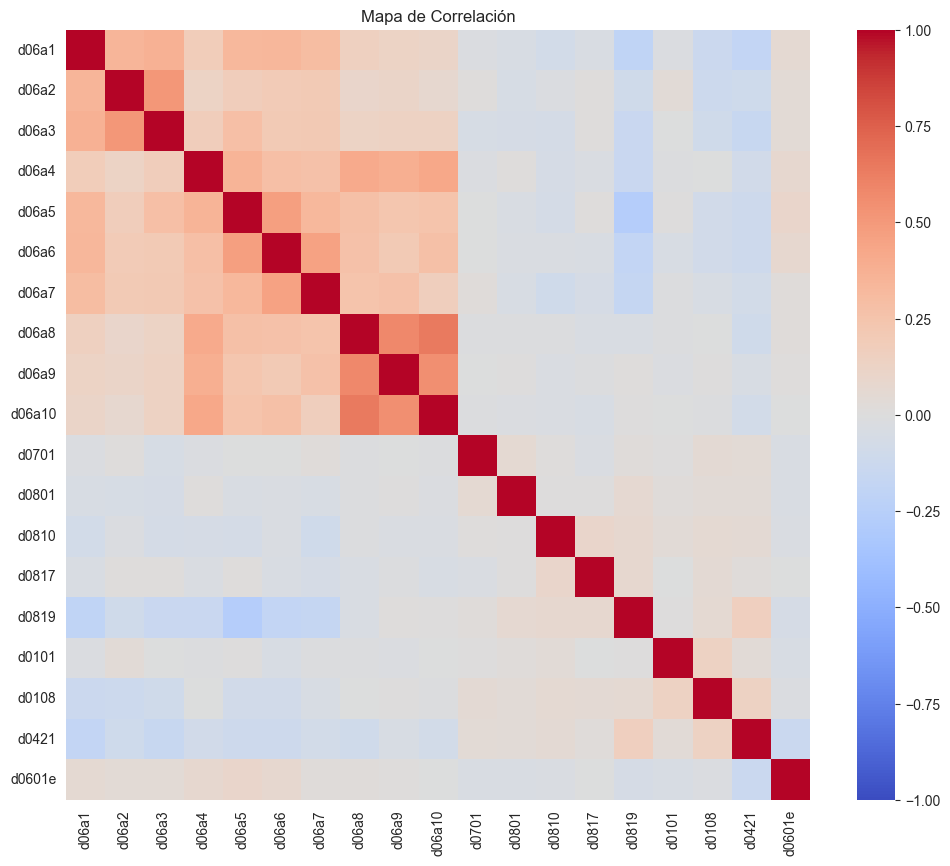

d06a8   d06a10    0.641805
d06a10  d06a8     0.641805
d06a8   d06a9     0.584085
d06a9   d06a8     0.584085
        d06a10    0.550175
d06a10  d06a9     0.550175
d06a3   d06a2     0.513320
d06a2   d06a3     0.513320
d06a5   d06a6     0.473803
d06a6   d06a5     0.473803
dtype: float64


In [7]:
# ==========================================
# 4.1 PREPARACIÓN DE DATOS // CORRELACIÓN Y D.R PREP.
# ==========================================

# Eliminamos columnas que no queremos incluir en la matriz de correlación
cols = ["edad", "sexo", "nivel_depresion"]
df_analisis = df_clean.drop(columns=cols)

# Calculamos la matriz de correlación entre las variables numéricas
plt.figure(figsize=(12, 10))
corr_matrix = df_analisis.corr()

# Graficamos el mapa de calor de correlaciones
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Correlación")
plt.show()

# Calculamos el valor absoluto de las correlaciones para ver las más fuertes
corr = df_analisis.corr().abs()

# Obtenemos las 10 correlaciones más altas entre pares de variables
top_corr = (
    corr.where(~np.eye(corr.shape[0], dtype=bool))
        .unstack()
        .dropna()
        .sort_values(ascending=False)
)

print(top_corr.head(10))


/Users/trianaflores/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/trianaflores/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


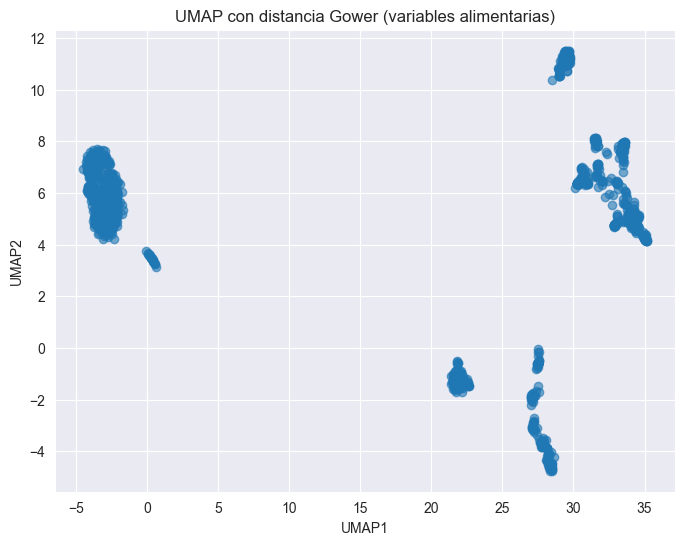

In [8]:
# ==========================================
# 5. UMAP - Reducción de dimensionalidad
# ==========================================
# Aplicamos UMAP únicamente a las variables alimentarias

cols_alimentacion = ft_alimentarias
X = df_analisis[cols_alimentacion].copy()
# X = X.astype('object')

# Calculamos la matriz de distancias de Gower para variables categóricas/mixtas
dist_matrix = gower.gower_matrix(X.astype('object'))

# Definimos el modelo UMAP con métrica 'precomputed' porque ya le pasamos la matriz de distancias
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='precomputed',
    random_state=42
)

# Ajustamos UMAP y obtenemos el embedding (coordenadas en 2D)
reducer.fit(dist_matrix)
coords_umap = reducer.embedding_

# Graficamos el embedding UMAP sin colorear
plt.figure(figsize=(8,6))
plt.scatter(coords_umap[:,0], coords_umap[:,1], alpha=0.6)
plt.title("UMAP con distancia Gower (variables alimentarias)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


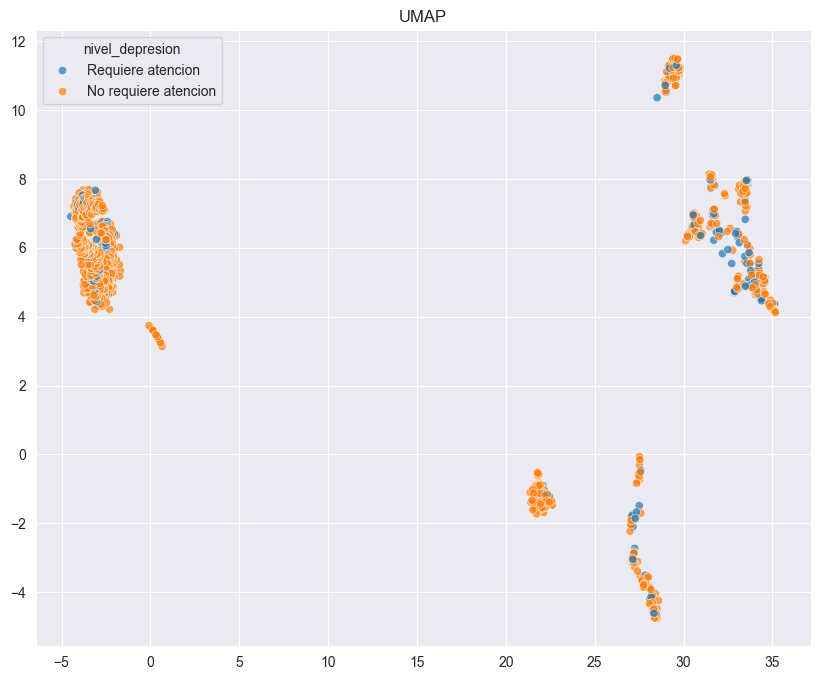

In [9]:
# Visualización del espacio UMAP coloreado por nivel de depresión

colores = df_clean['nivel_depresion']

plt.figure(figsize=(10, 8))
sns.scatterplot(x=coords_umap[:,0], y=coords_umap[:,1], hue=colores, alpha=0.7)
plt.title("UMAP")
plt.show()

In [10]:
# Mostramos las dimensiones de la matriz de distancias y del embedding UMAP
print("Shape matriz distancias:", dist_matrix.shape)
print("Shape embedding:", coords_umap.shape)

Shape matriz distancias: (1592, 1592)
Shape embedding: (1592, 2)


In [11]:
# Calculamos la varianza de cada componente UMAP (para ver cuál aporta más variación)
pd.DataFrame(coords_umap, columns=["UMAP1", "UMAP2"]).var()

UMAP1    264.051758
UMAP2     15.983983
dtype: float32

In [12]:
# ==========================================
# CREAR DATAFRAME DE UMAP PARA USO EN EL ÁRBOL
# ==========================================

# Convertimos las coordenadas UMAP a un DataFrame con índice alineado a df_clean
df_umap = pd.DataFrame(coords_umap, columns=["UMAP1", "UMAP2"], index=df_clean.index)

print(df_umap.head())
print(df_umap.shape)


       UMAP1     UMAP2
0  21.755678 -1.184516
1  28.417765 -4.596816
2  -2.299046  4.217237
3  27.087185 -3.093871
5  -1.689761  5.342722
(1592, 2)


In [13]:
# Integración de variables reducidas (UMAP) y selección final de predictores
# Unimos df_clean con UMAP1 y UMAP2 y eliminamos las variables alimentarias originales

df_final = pd.concat([df_clean, df_umap], axis=1)
df_final = df_final.drop(columns=ft_alimentarias)

# X = variables explicativas (incluye UMAP1 y UMAP2)
# y = variable objetivo (nivel_depresion)
X = df_final.drop(columns=['nivel_depresion'])
y = df_final['nivel_depresion']

In [14]:
# Definimos varias configuraciones de árboles de decisión para compararlas mediante validación cruzada

configuraciones = {
    'Árbol 1 - Poco profundo': {
        'max_depth': 3, 'min_samples_split': 50, 'min_samples_leaf': 20,
        'criterion': 'gini', 'class_weight': 'balanced'
    },
    'Árbol 2 - Moderado': {
        'max_depth': 5, 'min_samples_split': 30, 'min_samples_leaf': 15,
        'criterion': 'gini', 'class_weight': 'balanced'
    },
    'Árbol 3 - Profundo': {
        'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10,
        'criterion': 'gini', 'class_weight': 'balanced'
    },
    'Árbol 4 - Muy Profundo': {
        'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 8,
        'criterion': 'gini', 'class_weight': 'balanced'
    },
    'Árbol 5 - Entropy Moderado': {
        'max_depth': 5, 'min_samples_split': 30, 'min_samples_leaf': 15,
        'criterion': 'entropy', 'class_weight': 'balanced'
    },
    'Árbol 6 - Entropy Profundo': {
        'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10,
        'criterion': 'entropy', 'class_weight': 'balanced'
    }
}

# Función para entrenar y evaluar cada configuración de árbol con validación cruzada
def evaluar_modelo(nombre, config):
    # Creamos el árbol con la configuración dada
    modelo = DecisionTreeClassifier(random_state=42, **config)

    # Definimos qué clase será la positiva para el recall (labels ordenados alfabéticamente)
    labels = sorted(y.unique())
    pos_label = labels[1]

    # Métricas que vamos a calcular en la validación cruzada
    scoring = {
        'accuracy': 'accuracy',
        'f1_weighted': 'f1_weighted',
        'recall': make_scorer(recall_score, pos_label=pos_label, zero_division=0)
    }

    # Validación cruzada con 5 folds
    cv_results = cross_validate(modelo, X, y, cv=5, scoring=scoring)

    # Entrenamos el modelo final con todos los datos (por si queremos usarlo después)
    modelo.fit(X, y)

    # Regresamos todas las métricas promedio y el objeto modelo
    return {
        'Modelo': nombre,
        'Accuracy': cv_results['test_accuracy'].mean(),
        'F1_weighted': cv_results['test_f1_weighted'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'Std_Recall': cv_results['test_recall'].std(),
        'Config': config,
        'Objeto': modelo
    }

# Evaluamos todas las configuraciones de árbol
resultados = []
for nombre, cfg in configuraciones.items():
    resultados.append(evaluar_modelo(nombre, cfg))

# Creamos un DataFrame con los resultados y lo ordenamos por Recall (sensibilidad)
df_resultados = pd.DataFrame(resultados).sort_values("Recall", ascending=False)

print("\nResultados ordenados por Recall:")
print(df_resultados)

df_resultados



Resultados ordenados por Recall:
                       Modelo  Accuracy  F1_weighted    Recall  Std_Recall  \
4  Árbol 5 - Entropy Moderado  0.661410     0.705098  0.702612    0.040421   
1          Árbol 2 - Moderado  0.667735     0.711521  0.674367    0.056594   
0     Árbol 1 - Poco profundo  0.682112     0.721903  0.634531    0.046270   
2          Árbol 3 - Profundo  0.672763     0.714947  0.618531    0.061562   
5  Árbol 6 - Entropy Profundo  0.689064     0.727702  0.606204    0.059003   
3      Árbol 4 - Muy Profundo  0.692171     0.726157  0.517878    0.080174   

                                              Config  \
4  {'max_depth': 5, 'min_samples_split': 30, 'min...   
1  {'max_depth': 5, 'min_samples_split': 30, 'min...   
0  {'max_depth': 3, 'min_samples_split': 50, 'min...   
2  {'max_depth': 7, 'min_samples_split': 20, 'min...   
5  {'max_depth': 7, 'min_samples_split': 20, 'min...   
3  {'max_depth': 10, 'min_samples_split': 15, 'mi...   

                          

,Modelo,Accuracy,F1_weighted,Recall,Std_Recall,Config,Objeto
4,Árbol 5 - Entropy Moderado,0.661410,0.705098,0.702612,0.040421,"{'max_depth': 5, 'min_samples_split': 30, 'min...",DecisionTreeClassifier(class_weight='balanced'...
1,Árbol 2 - Moderado,0.667735,0.711521,0.674367,0.056594,"{'max_depth': 5, 'min_samples_split': 30, 'min...",DecisionTreeClassifier(class_weight='balanced'...
0,Árbol 1 - Poco profundo,0.682112,0.721903,0.634531,0.046270,"{'max_depth': 3, 'min_samples_split': 50, 'min...",DecisionTreeClassifier(class_weight='balanced'...
2,Árbol 3 - Profundo,0.672763,0.714947,0.618531,0.061562,"{'max_depth': 7, 'min_samples_split': 20, 'min...",DecisionTreeClassifier(class_weight='balanced'...
5,Árbol 6 - Entropy Profundo,0.689064,0.727702,0.606204,0.059003,"{'max_depth': 7, 'min_samples_split': 20, 'min...",DecisionTreeClassifier(class_weight='balanced'...
3,Árbol 4 - Muy Profundo,0.692171,0.726157,0.517878,0.080174,"{'max_depth': 10, 'min_samples_split': 15, 'mi...",DecisionTreeClassifier(class_weight='balanced'...


In [15]:
# ==========================================
# 6.A CHI-CUADRADA
# NIVEL DE DEPRESIÓN vs CONSUMO DE ALCOHOL
# ==========================================

# Filtramos solo valores válidos de consumo de alcohol (1 a 6)
df_chi = df_clean[df_clean['d0108'].isin([1, 2, 3, 4, 5, 6])]
tabla_chi = pd.crosstab(df_chi['nivel_depresion'], df_chi['d0108'])

# Construimos la tabla de contingencia entre nivel de depresión y consumo de alcohol
print("Tabla de contingencia: nivel_depresion x consumo de alcohol (d0108)")
print(tabla_chi)

# Aplicamos la prueba de chi-cuadrada de independencia
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print("\nResultados prueba chi-cuadrada:")
print(f"Chi2: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p:.5f}")

# Interpretación de la prueba
print("\nConclusión:")
if p < 0.05:
    print("Existe evidencia estadísticamente significativa de relación entre nivel de depresión y consumo de alcohol.")
else:
    print("No hay suficiente evidencia de que exista relación entre nivel de depresión y consumo de alcohol.")

Tabla de contingencia: nivel_depresion x consumo de alcohol (d0108)
d0108                 1   2   3    4    5    6
nivel_depresion                               
No requiere atencion  1  14  53  130  302  839
Requiere atencion     1   5  22   25   47  148

Resultados prueba chi-cuadrada:
Chi2: 15.688
Grados de libertad: 5
p-valor: 0.00779

Conclusión:
Existe evidencia estadísticamente significativa de relación entre nivel de depresión y consumo de alcohol.


In [16]:
# ==========================================
# 6.B CHI-CUADRADA
# NIVEL DE DEPRESIÓN vs ABUSO SEXUAL
# ==========================================

# Filtramos valores válidos para la variable de abuso sexual (d0810)
df_chi_abs = df_clean[df_clean['d0810'].isin([1, 2, 3])]

# Tabla de contingencia entre nivel de depresión y abuso sexual
tabla_chi_abs_dep = pd.crosstab(df_chi_abs['nivel_depresion'], df_chi_abs['d0810'])

print("Tabla de contingencia: nivel_depresion x abuso sexual (d0810)")
print(tabla_chi_abs_dep)

# Prueba chi-cuadrada
chi2, p, dof, expected = chi2_contingency(tabla_chi_abs_dep)

print("\nResultados prueba chi-cuadrada:")
print(f"Chi2: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p:.15f}")

# Interpretación de la prueba
print("\nConclusión:")
if p < 0.05:
    print("Existe evidencia estadísticamente significativa de relación entre nivel de depresión y abuso sexual.")
else:
    print("No hay suficiente evidencia de que exista relación entre nivel de depresión y abuso sexual.") #d0601e


Tabla de contingencia: nivel_depresion x abuso sexual (d0810)
d0810                  1  2     3
nivel_depresion                  
No requiere atencion  29  6  1294
Requiere atencion     25  5   210

Resultados prueba chi-cuadrada:
Chi2: 49.838
Grados de libertad: 2
p-valor: 0.000000000015058

Conclusión:
Existe evidencia estadísticamente significativa de relación entre nivel de depresión y abuso sexual.


In [17]:
# ==========================================
# 6.B CHI-CUADRADA
# NIVEL DE DEPRESIÓN vs SUEÑO
# ==========================================

# Tabla de contingencia entre nivel de depresión y calidad/tiempo de sueño (d0601e)
tabla_chi_sueno_dep = pd.crosstab(df_clean['nivel_depresion'], df_clean['d0601e'])

print("Tabla de contingencia: nivel_depresion x sueño (d0601e)")
print(tabla_chi_sueno_dep)

# Prueba chi-cuadrada
chi2, p, dof, expected = chi2_contingency(tabla_chi_sueno_dep)

print("\n")
print("Resultados prueba chi-cuadrada:")
print(f"Chi2: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p}")

# Interpretación de la prueba para sueño
if p < 0.05:
    print("\nConclusión: ")
    print(
        "Existe evidencia estadísticamente significativa de relación entre nivel de depresión y falta de sueño.")
else:
    print("\nConclusión: ")
    print("No se hay suficiente evidencia de que hay relación entre nivel de depresión y falta de sueño.")

Tabla de contingencia: nivel_depresion x sueño (d0601e)
d0601e                  1    2   3    4
nivel_depresion                        
No requiere atencion  879  186  48  230
Requiere atencion      94   70  44   41


Resultados prueba chi-cuadrada:
Chi2: 125.227
Grados de libertad: 3
p-valor: 5.7754259985451315e-27

Conclusión: 
Existe evidencia estadísticamente significativa de relación entre nivel de depresión y falta de sueño.
